### Chargement du dataset

In [25]:
import kagglehub as kh
import pandas as pd

# Télécharger le dataset dans un dossier local
dataset_ref = "venky73/spam-mails-dataset"
path = kh.dataset_download(dataset_ref)

# Localiser le fichier CSV dans le dossier téléchargé
csv_file = f"{path}/spam_ham_dataset.csv"

# Charger le fichier CSV dans un DataFrame
df = pd.read_csv(csv_file)

In [26]:
display(df)
df.info()

,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\r\nthis deal is t...,0
...,...,...,...,...
5166,1518,ham,Subject: put the 10 on the ft\r\nthe transport...,0
5167,404,ham,Subject: 3 / 4 / 2000 and following noms\r\nhp...,0
5168,2933,ham,Subject: calpine daily gas nomination\r\n>\r\n...,0
5169,1409,ham,Subject: industrial worksheets for august 2000...,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5171 entries, 0 to 5170
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  5171 non-null   int64 
 1   label       5171 non-null   object
 2   text        5171 non-null   object
 3   label_num   5171 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 161.7+ KB


### Préparation des données

In [27]:
# Suppression colonne inutiles
df = df.drop(['Unnamed: 0','label'],axis=1)

In [28]:
# Téléchargement des stopwords en anglais
import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords
stop_words_en = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\maxbe\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [29]:
# Suppression des stopwords 
def remove_stopwords(mail,language='english'):
    # Tokenize and filter out stopwords
    filtered_words = [word for word in mail.split() if word.lower() not in stop_words_en]
    # Join the filtered words back into a single string
    return ' '.join(filtered_words)

df['text']=df['text'].apply(remove_stopwords)

display(df)

,text,label_num
0,Subject: enron methanol ; meter # : 988291 fol...,0
1,"Subject: hpl nom january 9 , 2001 ( see attach...",0
2,"Subject: neon retreat ho ho ho , ' around wond...",0
3,"Subject: photoshop , windows , office . cheap ...",1
4,Subject: : indian springs deal book teco pvr r...,0
...,...,...
5166,Subject: put 10 ft transport volumes decreased...,0
5167,Subject: 3 / 4 / 2000 following noms hpl ' tak...,0
5168,Subject: calpine daily gas nomination > > juli...,0
5169,Subject: industrial worksheets august 2000 act...,0


In [30]:
# Séparation train / test
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(df['text'],df['label_num'],test_size=0.2)

# Vectorisation des features (1 feature = nb d'occurences de chaque mot)
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

import numpy as np
display(X_test_vectorized)

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 65481 stored elements and shape (1035, 44975)>

### Entraînement et évaluation Naive Bayes

In [31]:
from sklearn.naive_bayes import MultinomialNB

nb = MultinomialNB()
nb.fit(X_train_vectorized,y_train)
y_pred = nb.predict(X_test_vectorized)

display(pd.crosstab(y_test,y_pred,rownames=['Réel'],colnames=["Prédit"]))

from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

Prédit,0,1
Réel,,
0,729,4
1,12,290


              precision    recall  f1-score   support

           0       0.98      0.99      0.99       733
           1       0.99      0.96      0.97       302

    accuracy                           0.98      1035
   macro avg       0.99      0.98      0.98      1035
weighted avg       0.98      0.98      0.98      1035



In [32]:
# Exemple de spam
spam_ex = pd.Series("Congratulations! You have been selected to receive a brand new iPhone 15 — absolutely FREE! Just click the link below and claim your prize now before it’s gone! This is a limited-time offer. Act fast!")
print (nb.predict(vectorizer.transform(spam_ex)))

spam_ex = pd.Series("Congratulations! You have been selected to receive a brand new iPhone 15 — absolutely FREE! Just click the link below and claim your prize now before it’s gone! This is a limited-time offer. Act fast!" +15*"Enron ")
print (nb.predict(vectorizer.transform(spam_ex)))

[1]
[0]


Le modèle semble a priori très bon mais l'exemple nous montre une grosse faille.
Lorsque le modèle détecte Enron dans un mail, il le considère comme non-spam !

### Interprétabilité spécifique avec Naive Bayes

In [33]:
# Feature importances : on regarde la différence des log-probabilités
importance = np.abs(nb.feature_log_prob_[0,:]-nb.feature_log_prob_[1,:])
display (pd.DataFrame(importance,index=vectorizer.get_feature_names_out()).sort_values(0,ascending=False))


,0
enron,7.955109
ect,7.335747
meter,7.025787
hpl,6.962299
daren,6.782358
...,...
pacific,0.001138
650,0.001138
329,0.001138
owes,0.001138


### Entraînement et évaluation Random Forest

In [34]:
from sklearn.ensemble import RandomForestClassifier

# Convertir la matrice sparse en dense pour la compatibilité
X_train_dense = X_train_vectorized.toarray()
X_test_dense = X_test_vectorized.toarray()

rfc = RandomForestClassifier()
rfc.fit(X_train_dense,y_train)
y_pred = rfc.predict(X_test_dense)

display(pd.crosstab(y_test,y_pred,rownames=['Réel'],colnames=["Prédit"]))
print(classification_report(y_test,y_pred))

Prédit,0,1
Réel,,
0,724,9
1,10,292


              precision    recall  f1-score   support

           0       0.99      0.99      0.99       733
           1       0.97      0.97      0.97       302

    accuracy                           0.98      1035
   macro avg       0.98      0.98      0.98      1035
weighted avg       0.98      0.98      0.98      1035



In [35]:
# Exemple de spam
spam_ex = pd.Series("Congratulations! You have been selected to receive a brand new iPhone 15 — absolutely FREE! Just click the link below and claim your prize now before it’s gone! This is a limited-time offer. Act fast!")
print (rfc.predict(vectorizer.transform(spam_ex)))

spam_ex = pd.Series("Congratulations! You have been selected to receive a brand new iPhone 15 — absolutely FREE! Just click the link below and claim your prize now before it’s gone! This is a limited-time offer. Act fast!" +15*"Enron ")
print (rfc.predict(vectorizer.transform(spam_ex)))

[1]
[1]


### Interprétabilité spécifique avec Random Forest

In [36]:
# On récupère directement les feature importances du modèle
display (pd.DataFrame(rfc.feature_importances_,index=vectorizer.get_feature_names_out()).sort_values(0,ascending=False))


,0
http,0.016924
enron,0.016030
2000,0.015898
hpl,0.013970
attached,0.013490
...,...
zvjc,0.000000
zvp,0.000000
0074,0.000000
000000000049773,0.000000


### Entraînement et évaluation LightGBM

In [37]:
import lightgbm as lgb

# Entraîner un modèle LightGBM
model_lgbm = lgb.LGBMClassifier(n_estimators=300, random_state=0, verbosity=-1)
model_lgbm.fit(X_train_dense, y_train)

y_pred = model_lgbm.predict(X_test_dense)

display(pd.crosstab(y_test,y_pred,rownames=['Réel'],colnames=["Prédit"]))
print(classification_report(y_test,y_pred))

d:\Sources\DS-Machine-Learning\AdvancedML\env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Prédit,0,1
Réel,,
0,719,14
1,7,295


              precision    recall  f1-score   support

           0       0.99      0.98      0.99       733
           1       0.95      0.98      0.97       302

    accuracy                           0.98      1035
   macro avg       0.97      0.98      0.98      1035
weighted avg       0.98      0.98      0.98      1035



In [38]:
# Exemple de spam
spam_ex = pd.Series("Congratulations! You have been selected to receive a brand new iPhone 15 — absolutely FREE! Just click the link below and claim your prize now before it’s gone! This is a limited-time offer. Act fast!")
print (model_lgbm.predict(vectorizer.transform(spam_ex).toarray()))

spam_ex = pd.Series("Congratulations! You have been selected to receive a brand new iPhone 15 — absolutely FREE! Just click the link below and claim your prize now before it’s gone! This is a limited-time offer. Act fast!" +15*"Enron ")
print (model_lgbm.predict(vectorizer.transform(spam_ex).toarray()))

[1]
[0]


d:\Sources\DS-Machine-Learning\AdvancedML\env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
d:\Sources\DS-Machine-Learning\AdvancedML\env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


### Interprétabilité SHAP TreeExplainer avec LightGBM

d:\Sources\DS-Machine-Learning\AdvancedML\env\Lib\site-packages\shap\explainers\_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


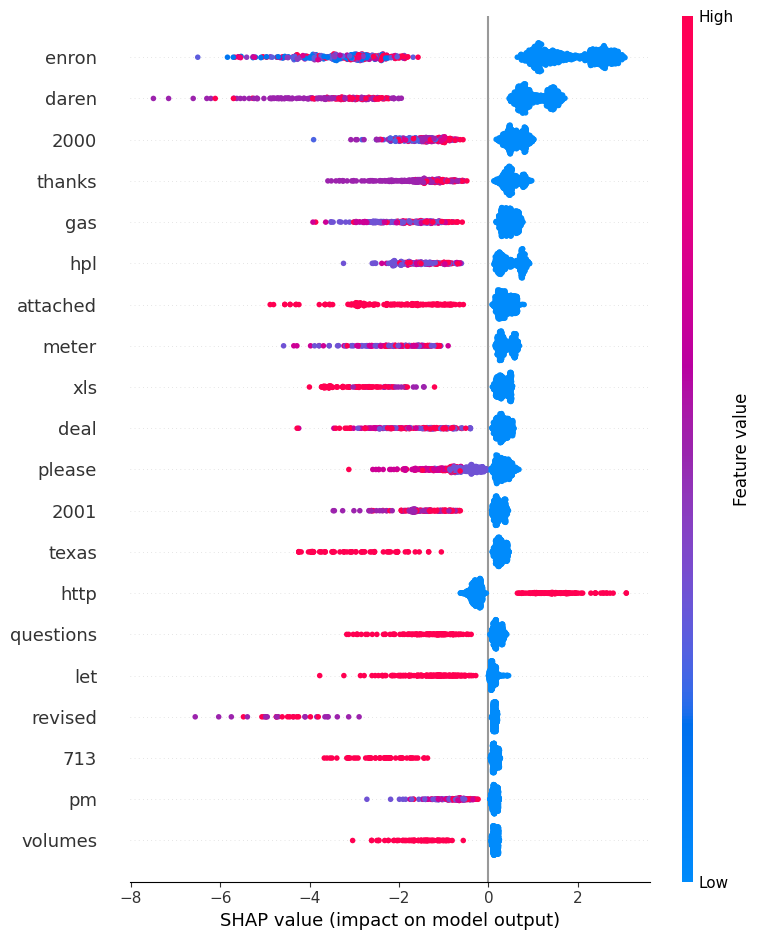

In [39]:
# Interprétabilité GLOBALE avec SHAP TreeExplainer
import shap

# Créer un explainer SHAP pour le modèle LGMB
explainer = shap.TreeExplainer(model_lgbm)

# Calculer les valeurs SHAP pour le dataset de test
shap_values = explainer.shap_values(X_test_dense)  # Retourne une matrice unique pour la classification binaire

# Visualiser le graphique récapitulatif pour voir l'importance des features (interprétation globale)
shap.summary_plot(shap_values, X_test_dense, feature_names=vectorizer.get_feature_names_out())


Ce sont les mots (features) les plus importants pour la prédiction.

La présence de Enron a une tendance à classer un mail en non spam.

La présence de http a tendance à classer un mail en spam. Son absence a peu d'influence

Subject: : basin production ga 213 daren , ' received word basin bring production sometime today tomorrow ( expect get b / 10 , 000 - 15 , 000 ) ; facility planning engineer determines take gas , flow february priced 100 % gas daily less $ 0 . 16 . vlt daren j farmer 01 / 25 / 2001 01 : 47 pm : vance l taylor / hou / ect @ ect cc : subject : : basin production ga 213 need , producer services group , determine think gas flow month price . use decision bidweek postion . vance l taylor 01 / 25 / 2001 11 : 53 : daren j farmer / hou / ect @ ect , robert cotten / hou / ect @ ect cc : susan smith / hou / ect @ ect , melissa graves / hou / ect @ ect subject : basin production ga 213 fyi , would want handle february nomination ? vlt x 3 - 6353 - - - - - - - - - - - - - - - - - - - - - - forwarded vance l taylor / hou / ect 01 / 25 / 2001 11 : 55 - - - - - - - - - - - - - - - - - - - - - - - - - - - enron north america corp . : brad blevins 01 / 25 / 2001 10 : 56 : john peyton / hou / ect @ ect 

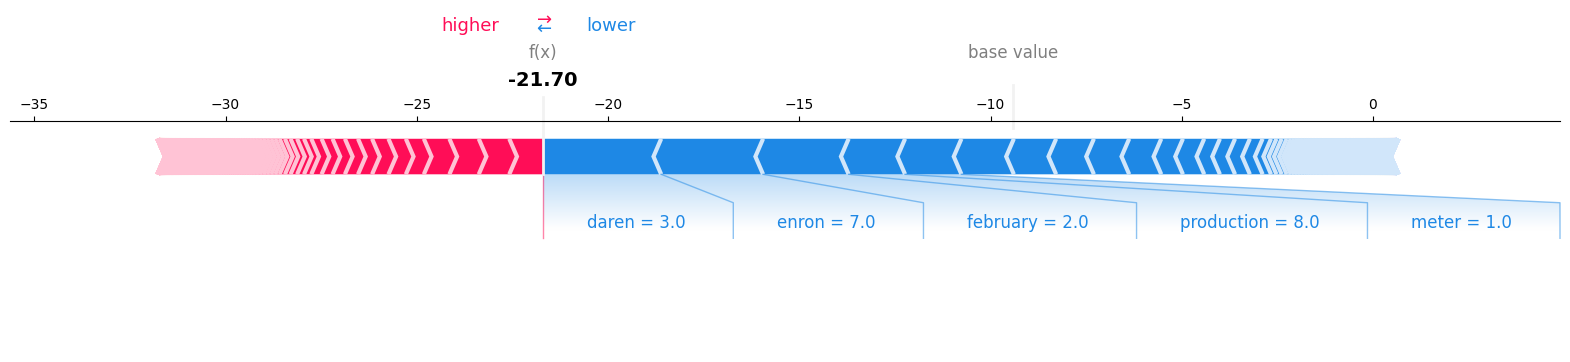

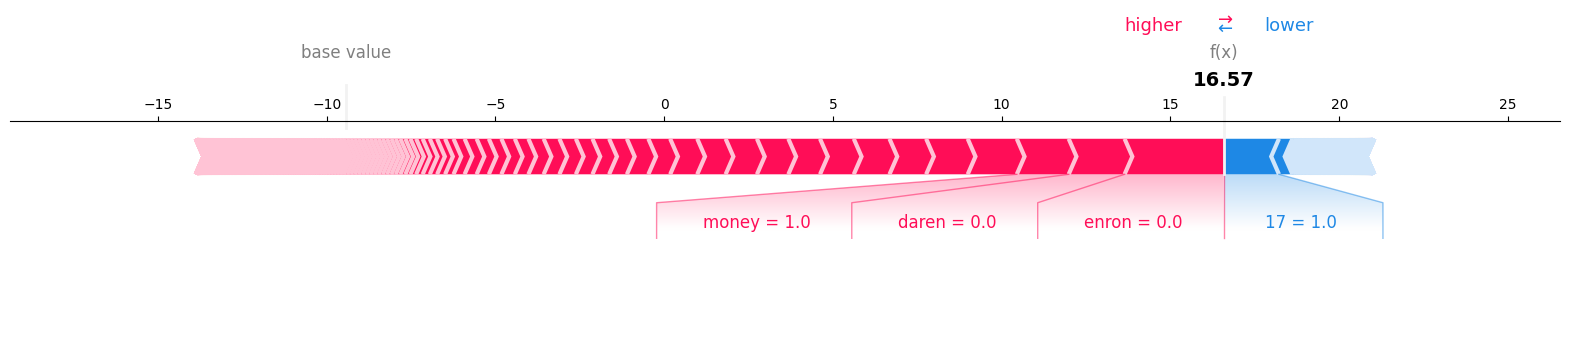

In [40]:
# Interprétabilité LOCALE avec SHAP TreeExplainer

# Trouver un spam
print(X_test.iloc[1])

# Trouver un mail légitime
print(X_test.iloc[3])

# Générer le diagramme de force pour ce spam
shap.force_plot(
    explainer.expected_value, 
    shap_values[1], 
    X_test_dense[1], 
    feature_names=vectorizer.get_feature_names_out(),
    matplotlib=True
)

# Générer le diagramme de force pour ce mail légitime
shap.force_plot(
    explainer.expected_value, 
    shap_values[3], 
    X_test_dense[3], 
    feature_names=vectorizer.get_feature_names_out(),
    matplotlib=True
)

Le 1er mail a été classé comme non-spam grâce à la présence d'enron, de daren, etc.

Le 2ème mail a été classé comme spam grâce à la présence de money, l'absence de daren et enron, et malgré la présence de 17.

### Interprétabilité Permutation Importance avec LightGBM (Très long...)

In [ ]:
from sklearn.inspection import permutation_importance
result = permutation_importance(model_lgbm, X_test_dense[:10,:], y_test[:10], n_repeats=5, random_state=42)
importance_df = pd.DataFrame(
    {
        k: result[k] for k in ("importances_mean","importances_std")
    },
    index=vectorizer.get_feature_names_out(),
).sort_values(by="importances_mean", ascending=False)

display(importance_df)

### Correction de biais de contenu

In [ ]:
# On retire les mots spécifiques à l'entreprise avant entraînement du modèle
all_words = vectorizer.get_feature_names_out()
filtred_words = all_words[~np.isin(all_words, ['daren','enron'])]

vectorizer = CountVectorizer(vocabulary=filtred_words)
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

X_train_dense = X_train_vectorized.toarray()
X_test_dense = X_test_vectorized.toarray()

model_lgbm.fit(X_train_dense, y_train)

y_pred = model_lgbm.predict(X_test_dense)

display(pd.crosstab(y_test,y_pred,rownames=['Réel'],colnames=["Prédit"]))
print(classification_report(y_test,y_pred))

d:\Sources\DS-Machine-Learning\AdvancedML\env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Prédit,0,1
Réel,,
0,718,15
1,15,287


              precision    recall  f1-score   support

           0       0.98      0.98      0.98       733
           1       0.95      0.95      0.95       302

    accuracy                           0.97      1035
   macro avg       0.96      0.96      0.96      1035
weighted avg       0.97      0.97      0.97      1035



In [47]:
# Exemple de spam
spam_ex = pd.Series("Congratulations! You have been selected to receive a brand new iPhone 15 — absolutely FREE! Just click the link below and claim your prize now before it’s gone! This is a limited-time offer. Act fast!")
print (model_lgbm.predict(vectorizer.transform(spam_ex).toarray()))

spam_ex = pd.Series("Congratulations! You have been selected to receive a brand new iPhone 15 — absolutely FREE! Just click the link below and claim your prize now before it’s gone! This is a limited-time offer. Act fast!" +15*"Enron ")
print (model_lgbm.predict(vectorizer.transform(spam_ex).toarray()))

[1]
[1]


d:\Sources\DS-Machine-Learning\AdvancedML\env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
d:\Sources\DS-Machine-Learning\AdvancedML\env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


d:\Sources\DS-Machine-Learning\AdvancedML\env\Lib\site-packages\shap\explainers\_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


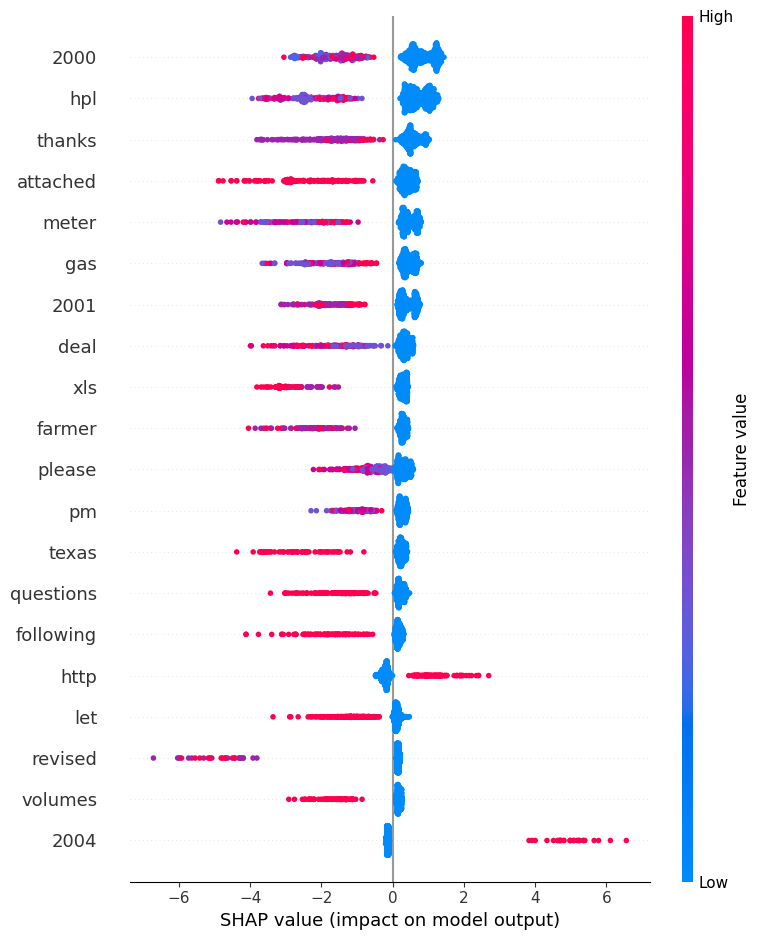

In [48]:
# Interprétabilité GLOBALE avec SHAP TreeExplainer

# Créer un explainer SHAP pour le modèle LGMB
explainer = shap.TreeExplainer(model_lgbm)

# Calculer les valeurs SHAP pour le dataset de test
shap_values = explainer.shap_values(X_test_dense)  # Retourne une matrice unique pour la classification binaire

# Visualiser le graphique récapitulatif pour voir l'importance des features (interprétation globale)
shap.summary_plot(shap_values, X_test_dense, feature_names=vectorizer.get_feature_names_out())